
DATASET

In [ ]:
# Instala dependencias
!pip -q install torchxrayvision
!pip install imutils
# Descarga el dataset
!git clone https://github.com/ieee8023/covid-chestxray-dataset

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [ ]:
# Importa librerías
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import json, time, datetime
import torchxrayvision as xrv
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch  
import torchvision
import torchxrayvision as xrv
import pylab
import torch.optim as optim
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import copy

In [ ]:
%%bash
rm -rf images
mkdir -p images/covid
mkdir -p images/no-covid

In [ ]:
# Definir dataset
dataset = xrv.datasets.COVID19_Dataset(
    imgpath="covid-chestxray-dataset/images/", 
    csvpath="covid-chestxray-dataset/metadata.csv"
)

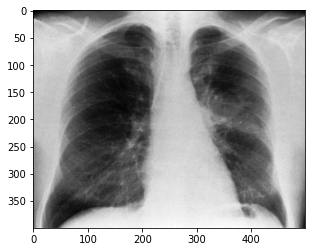

In [ ]:
sample = random.choice(dataset)
plt.imshow(sample["img"][0], cmap="gray")

In [ ]:
# Categoriza las imágenes covid y no-covid
for sample in dataset:
  covid = sample['lab'][3]
  image_name = '%s.png' % sample["idx"]
  if covid:
    # Covid
    image_path = os.path.sep.join(["images", 'covid', image_name]) 

    if os.path.exists(image_path):
        continue
      
    data = Image.fromarray(sample["img"][0])
    if data.mode != 'RGB':
        data = data.convert('RGB')
    data.save(image_path)

  else:
    # No covid
    image_path = os.path.sep.join(["images", 'no-covid', image_name])

    if os.path.exists(image_path):
        continue
        
    data = Image.fromarray(sample["img"][0])
    if data.mode != 'RGB':
        data = data.convert('RGB')
        
    data.save(image_path)

In [ ]:
pd.Series(dict(zip(data.pathologies, sample["lab"])))

Aspergillosis     0.0
Aspiration        0.0
Bacterial         0.0
COVID-19          0.0
Chlamydophila     0.0
Fungal            0.0
H1N1              0.0
Herpes            0.0
Influenza         0.0
Klebsiella        0.0
Legionella        0.0
Lipoid            0.0
MERS-CoV          0.0
MRSA              0.0
Mycoplasma        0.0
No Finding        0.0
Nocardia          0.0
Pneumocystis      0.0
Pneumonia         1.0
SARS              1.0
Staphylococcus    0.0
Streptococcus     0.0
Tuberculosis      0.0
Varicella         0.0
Viral             1.0
dtype: float64

Crear dataframe: id, imag y etiqueta covid-19

In [ ]:
# full details about the image is available in the pandas csv
#metadata 

index                                                                     0
patientid                                                                 2
offset                                                                    0
sex                                                                       M
age                                                                      65
finding                                            Pneumonia/Viral/COVID-19
RT_PCR_positive                                                           Y
survival                                                                  Y
intubated                                                                 N
intubation_present                                                        N
went_icu                                                                  N
in_icu                                                                    N
needed_supplemental_O2                                                    Y
extubated   

In [ ]:
pathologies = d.csv.finding.str.split("/", expand=True).values.ravel()
pathologies = pathologies[~pd.isnull(pathologies)]
pathologies = sorted(np.unique(pathologies))

In [ ]:
pathologies

['Aspergillosis',
 'Aspiration',
 'Bacterial',
 'COVID-19',
 'Chlamydophila',
 'Fungal',
 'H1N1',
 'Herpes ',
 'Influenza',
 'Klebsiella',
 'Legionella',
 'Lipoid',
 'MERS-CoV',
 'MRSA',
 'Mycoplasma',
 'No Finding',
 'Nocardia',
 'Pneumocystis',
 'Pneumonia',
 'SARS',
 'Staphylococcus',
 'Streptococcus',
 'Tuberculosis',
 'Varicella',
 'Viral']

#####TRANSFER LEARNING 

#####ejemplo para una imagen

In [ ]:
def transformar_imagen(name):
  '''
  Pre procesamiento de la imagen
  '''
  transf = T.Compose([T.Resize(255),
                      T.CenterCrop(224),
                      T.ToTensor(), # entre 0 y 1
                      T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]) # medias y desviacion estandar (Welford's method)
  image = Image.open(name)
  # Tamaño (3,224,224) => (1, 3, 224, 224)
  return transf(image).unsqueeze(0) # tensor singleton

# Lista de clases disponibles
clases = d

def prediccion(network, name):
  '''
  se agrupan las funciones para predecir la clase de la imagen
  '''
  tensor = transformar_imagen(name)
  network.eval()
  pred = network(tensor)
  output = F.softmax(pred, dim=-1)
  _,val = output.max(1)
  index = str(val.item())
  return clases[index]

#####para nuestro dataset

In [ ]:
dataset = datasets.ImageFolder('images',
                              transform=transforms.Compose([
                                  #transforms.RandomResizedCrop(224),
                                  transforms.Resize(255),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                  ]))

class_names = dataset.classes
print(class_names)

['covid', 'no-covid']


In [ ]:
# Particionamos en subconjuntos de entrenamiento y prueba
n_test = int(len(dataset) * 0.2)
n_train = len(dataset) - n_test

train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

print(f'n_train={len(train_dataset)}')
print(f'n_test={len(test_dataset)}')

n_train=428
n_test=107


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

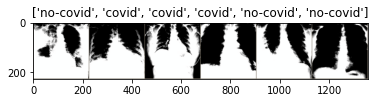

In [ ]:
# Mostramos algunos ejemplos
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

######entrenamiento

In [ ]:
# Función de entrenamiento y validación
def train_model(model, criterion, optimizer, scheduler, num_epochs = 30):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  rs = '------------------------------------------------------------------'
  print('Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best')
  print(rs)
  
  for epoch in range(num_epochs):
    #print(f'Epoch {epoch}/{num_epochs-1}')
    #print('-' * 10)
    
    # Entrenamiento
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
        
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    result = {}
    result['train_loss'] = running_loss /len(train_dataset)
    result['train_acc'] = running_corrects.double() / len(train_dataset)
      
    #print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    scheduler.step()
    
    # Validación 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    result['val_loss'] = running_loss /len(test_dataset)
    result['val_acc'] = running_corrects.double() / len(test_dataset)
    epoch_acc = result['val_acc']
      
    #print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    st = '          '
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      st = '   ***    '
        
    print("%5d %11.4f %11.4f %11.4f %11.4f %s" % (epoch, result['train_loss'], result['train_acc'], result['val_acc'], result['val_acc'], st))

  print(rs)
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val accucary: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)
  return model

In [ ]:
# Definimos el modelo
ft_model = models.resnet18(pretrained=True)
print(ft_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Modificamos la última capa y entrenamos
device = ('cuda' if torch.cuda.is_available() else 'cpu')

ft_model.fc = nn.Sequential(nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Linear(256, 128),
                            nn.ReLU(),
                            nn.Linear(128, 64),
                            nn.ReLU(),
                            nn.Linear(64, 2))
ft_model = ft_model.to(device)

ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.005, momentum=0.9)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=7, gamma=0.1)

ft_model = train_model(ft_model, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=35)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.6665      0.6005      0.6262      0.6262    ***    
    1      0.6168      0.6425      0.6636      0.6636    ***    
    2      0.5705      0.6939      0.5327      0.5327           
    3      0.5489      0.7453      0.6262      0.6262           
    4      0.4969      0.7360      0.7477      0.7477    ***    
    5      0.4571      0.7850      0.6449      0.6449           
    6      0.4056      0.8131      0.6355      0.6355           
    7      0.2981      0.8808      0.7570      0.7570    ***    
    8      0.1835      0.9299      0.7103      0.7103           
    9      0.1661      0.9486      0.7570      0.7570           
   10      0.1286      0.9556      0.7383      0.7383           
   11      0.1263      0.9556      0.7570      0.7570           
   12      0.1076      0.9673      0.7383      0.7383           
   13      0.0700      0.98

In [ ]:
# Modificamos la última capa y entrenamos
device = ('cuda' if torch.cuda.is_available() else 'cpu')

ft_model.fc = nn.Linear(512, 2)
ft_model = ft_model.to(device)

ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.003, momentum=0.9)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=7, gamma=0.1)

ft_model = train_model(ft_model, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=30)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      1.3836      0.5748      0.6262      0.6262    ***    
    1      1.4885      0.5678      0.6542      0.6542    ***    
    2      0.9271      0.6121      0.6168      0.6168           
    3      0.6701      0.7103      0.6542      0.6542           
    4      0.5466      0.7687      0.7009      0.7009    ***    
    5      0.5057      0.8107      0.7009      0.7009           
    6      0.5919      0.7593      0.7383      0.7383    ***    
    7      0.2415      0.8925      0.7477      0.7477    ***    
    8      0.1613      0.9393      0.7383      0.7383           
    9      0.1264      0.9603      0.7383      0.7383           
   10      0.1226      0.9533      0.7383      0.7383           
   11      0.1201      0.9579      0.7383      0.7383           
   12      0.0834      0.9743      0.7570      0.7570    ***    
   13      0.0961      0.96

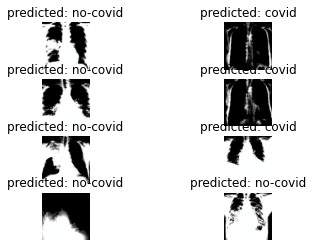

In [ ]:
# Mostramos las predicciones
def visualize_model(model, num_images = 8):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

visualize_model(ft_model)